In [36]:
import torch # CUDA 12.6 version used
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np

In [37]:
# Hyperparameters

batch_size = 128
epoch_num = 40
patience = 3
learning_rate = 0.001

In [38]:
# Set device to GPU if available

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Arrange datasets

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

all_training_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testing_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_size = int(0.9 * len(all_training_data))
validation_size = len(all_training_data) - training_size
training_data, validation_data = random_split(all_training_data, [training_size, validation_size])

training_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=2)
testing_loader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [39]:
# CNN setup

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(stride=2, kernel_size=2)
        
        # Convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = self.pool(func.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = func.relu(self.fc1(x))
        x = func.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model = CNN()
model.to(device)
crit = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)


In [40]:
# Model training and validation

max_validation_loss = float('inf')
stop_count = 0
training_loss_values = []
validation_loss_values = []
final_epoch = 0

for epoch in range(epoch_num):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        opt.zero_grad()
        outputs = model(inputs)
        loss = crit(outputs, labels)
        loss.backward()
        opt.step()
        running_loss += loss.item()
    training_loss = running_loss / len(training_loader)
    training_loss_values.append(training_loss)
            
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for validation_inputs, validation_labels in validation_loader:
            validation_inputs, validation_labels = validation_inputs.to(device), validation_labels.to(device)
            validation_outputs = model(validation_inputs)
            validation_loss += crit(validation_outputs, validation_labels).item()
    validation_loss /= len(validation_loader)
    validation_loss_values.append(validation_loss)        
        
    print(f"Epoch {epoch+1}: Training Loss = {training_loss:.3f}, Validation Loss = {validation_loss:.3f}")
    
    if validation_loss < max_validation_loss:
        max_validation_loss = validation_loss
        torch.save(model.state_dict(), "cnn_model.pth")
        stop_counter = 0
        final_epoch = epoch + 1
    else:
        stop_counter += 1
        if stop_counter >= patience:
            final_epoch = epoch + 1
            break

print("done")

Epoch 1: Training Loss = 1.755, Validation Loss = 1.536
Epoch 2: Training Loss = 1.434, Validation Loss = 1.358
Epoch 3: Training Loss = 1.286, Validation Loss = 1.228
Epoch 4: Training Loss = 1.175, Validation Loss = 1.152
Epoch 5: Training Loss = 1.101, Validation Loss = 1.101
Epoch 6: Training Loss = 1.030, Validation Loss = 1.033
Epoch 7: Training Loss = 0.972, Validation Loss = 1.044
Epoch 8: Training Loss = 0.916, Validation Loss = 0.956
Epoch 9: Training Loss = 0.875, Validation Loss = 0.948
Epoch 10: Training Loss = 0.839, Validation Loss = 0.912
Epoch 11: Training Loss = 0.802, Validation Loss = 0.927
Epoch 12: Training Loss = 0.765, Validation Loss = 0.892
Epoch 13: Training Loss = 0.735, Validation Loss = 0.893
Epoch 14: Training Loss = 0.704, Validation Loss = 0.906
Epoch 15: Training Loss = 0.683, Validation Loss = 0.869
Epoch 16: Training Loss = 0.656, Validation Loss = 0.838
Epoch 17: Training Loss = 0.635, Validation Loss = 0.866
Epoch 18: Training Loss = 0.617, Validat

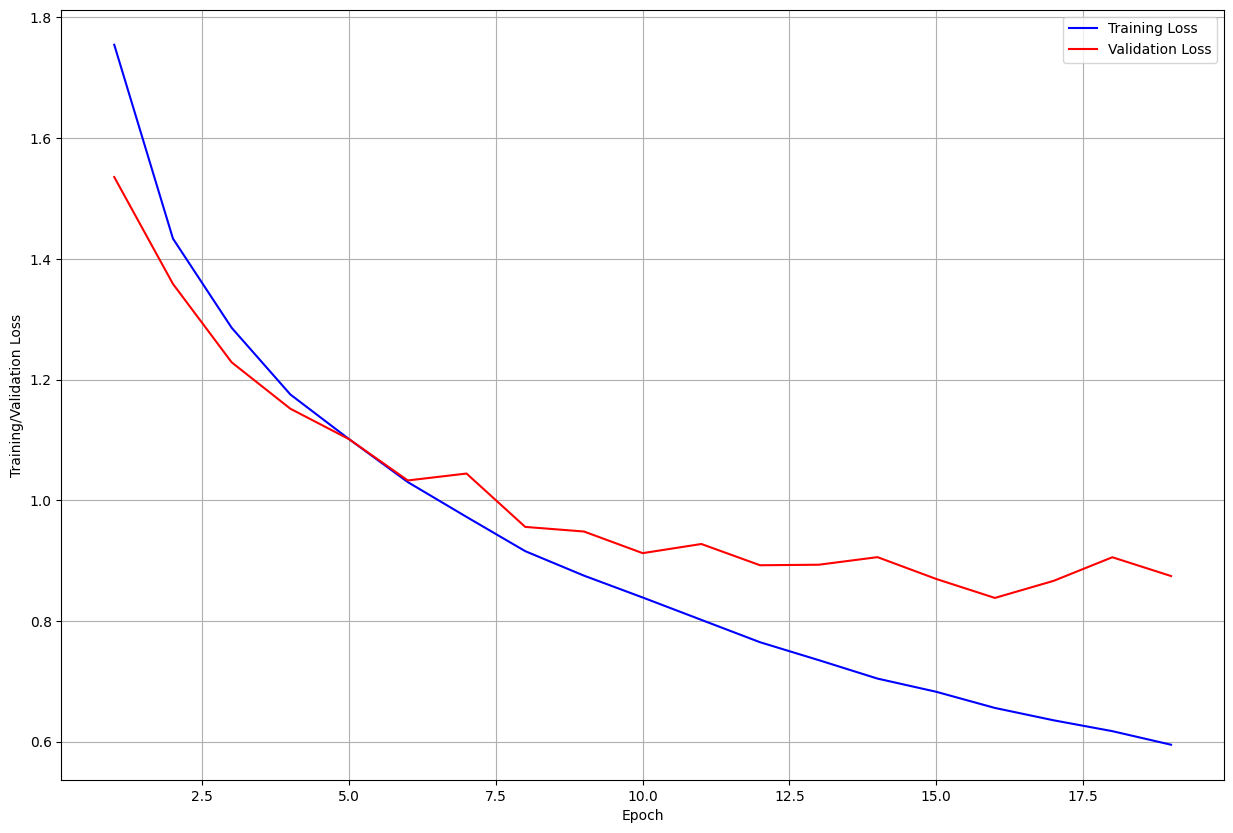

In [51]:
# Task 1 convergence graph

x_vals = list(range(1, epoch+2))
plt.figure(figsize=(15,10))
plt.plot(x_vals, training_loss_values, color='b', label='Training Loss')
plt.plot(x_vals, validation_loss_values, color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Training/Validation Loss')
plt.grid(True)
plt.legend()
plt.show()